# Natural Language Processing: News Analysis
[Peter Damyanov](https://github.com/petardmnv)

###### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
#nltk.download()
#from nltk.book import *

import requests

from datetime import datetime

from bs4 import BeautifulSoup

import re

import collections

### Abstract

### Research objective

### Theoretical background and hypothesis development

###  Methodology

### Implementing methodology

###### 1.Web Scraping

Get the most popular business news from [CNN](https://edition.cnn.com/business) for the current day.
Get the most popular business news from [BBC](https://www.bbc.com/news/business) for the current day.

**Warning** Scraping two completely different sites is not easy and most of the code will be different. Ie we will not be able to use the functions we have for both sites, but the logic in functions will be almost the same.

In [2]:
cnn_link = 'https://edition.cnn.com/business'
bbc_link = 'https://www.bbc.com/news/business'    

In [3]:
#Get page content
def get_page_content(link):
    page = requests.get(link)
    return page

Secondly we are going to scrape this page, so we can access "top news" urls. To scrape the page we need BeautifulSoup object. 

In [4]:
def create_soup(page):
    soup = BeautifulSoup(page.text, 'html.parser')
    return soup

There are duplicating links so we are going to create function which will remove duplicated links. The easiest way of doing that is to cast "links" to set, because set items are unordered, unchangeable, and do not allow duplicate values.

In [5]:
def clear_duplicate_links(links):
    return list(set(links))

ASDFFGASD

In [6]:
def remove_usless_links(pat, links):
    correct_links = []
    for l in links:
        obj = re.findall(pat, l)
        if len(obj) > 0:
            correct_links.append(obj[0])
    return list(set(correct_links))

Start with CNN

Extact links from scraped data and clear duplicating, if there is such links.

In [7]:
def extract_cnn_links(link):
    page = get_page_content(link)
    soup = create_soup(page)
    cnn_extracted_links = [l['href'] for l in soup.find('section').find("ul").find_all('a')]
    cnn_extracted_links = clear_duplicate_links(cnn_extracted_links)
    # Use regex to be sure that there is no wrong link
    pat = r"/\d{4}/\d{2}/\d{2}.*"
    cnn_extracted_links = remove_usless_links(pat, cnn_extracted_links)
    return cnn_extracted_links

Let's see extracted links from cnn.

In [8]:
extracted_cnn_links = extract_cnn_links(cnn_link)
extracted_cnn_links

['/2021/08/11/tech/rand-paul-youtube-suspension/index.html',
 '/2021/08/10/investing/tesla-china-sales/index.html',
 '/2021/08/09/business/money/early-retirement-fire-feseries/index.html',
 '/2021/08/11/media/andrew-cuomo-resignation-late-night-reaction/index.html',
 '/2021/08/10/energy/cambo-oilfield-shell-siccar-point/index.html',
 '/2021/08/10/investing/softbank-vision-fund-china-tech-intl-hnk/index.html',
 '/2021/08/10/business/raises-inflation-wages/index.html',
 '/2021/08/09/politics/cryptocurrency-infrastructure-deal-lummis-toomey/index.html',
 '/2021/08/09/tech/radiative-cooling-skycool-electricity-environment/index.html',
 '/2021/08/10/investing/citi-vaccine-mandate/index.html',
 '/2021/08/10/investing/robinhood-stock/index.html',
 '/2021/08/11/tech/crypto-hack/index.html',
 '/2021/08/11/perspectives/betterup-leadership-pandemic/index.html']

As you can see we can get article type from it's link. So let's create function that gets the article type.

In [9]:
def get_cnn_news_type_from_link(links):
    #link contains date of publishing than article type
    #For example /2021/08/06/economy/july-jobs-report/index.html
    # So we can remove first 12 characters and than get article type
    cnn_news_types = []
    for link in links:
        link = link[12:]
        # To determine the end ot article we will append to our variable character after character until we
        # get to '/' 
        news_type = []
        for c in link:
            if c == '/':
                break
            news_type.append(c)
        cnn_news_types.append("".join(news_type))
    return cnn_news_types

In [10]:
cnn_news_types = get_cnn_news_type_from_link(extracted_cnn_links)    
cnn_news_types

['tech',
 'investing',
 'business',
 'media',
 'energy',
 'investing',
 'business',
 'politics',
 'tech',
 'investing',
 'investing',
 'tech',
 'perspectives']

We can plot the results using bar chart to see the type of news that occurs most.

In [11]:
news_types_frequency = nltk.FreqDist(cnn_news_types)

In [12]:
def plot_types_of_news(news_types_frequency):
    plt.bar([t for t in news_types_frequency], [news_types_frequency[t] for t in news_types_frequency])

    plt.xlabel("News Type")
    plt.ylabel("Count news")
    plt.show()

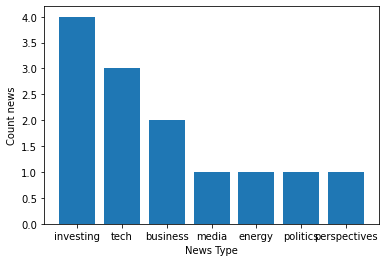

In [13]:
plot_types_of_news(news_types_frequency)

Then we want to know the date of current article. Again we can get it from article url.

In [14]:
def get_cnn_news_date(links):
    cnn_news_timestamp = []
    for link in links:
        raw_date = link[1:11]
        cnn_news_timestamp.append(raw_date.replace('/', '-'))
    return cnn_news_timestamp

In [15]:
cnn_news_timestamp = get_cnn_news_date(extracted_cnn_links)
cnn_news_timestamp

['2021-08-11',
 '2021-08-10',
 '2021-08-09',
 '2021-08-11',
 '2021-08-10',
 '2021-08-10',
 '2021-08-10',
 '2021-08-09',
 '2021-08-09',
 '2021-08-10',
 '2021-08-10',
 '2021-08-11',
 '2021-08-11']

Add domain to our links.

In [16]:
def cnn_news_add_domain(domain, links):
    for i in range(len(links)):
        links[i] = domain+links[i]

In [17]:
domain = 'https://edition.cnn.com'
cnn_news_add_domain(domain, extracted_cnn_links)
extracted_cnn_links

['https://edition.cnn.com/2021/08/11/tech/rand-paul-youtube-suspension/index.html',
 'https://edition.cnn.com/2021/08/10/investing/tesla-china-sales/index.html',
 'https://edition.cnn.com/2021/08/09/business/money/early-retirement-fire-feseries/index.html',
 'https://edition.cnn.com/2021/08/11/media/andrew-cuomo-resignation-late-night-reaction/index.html',
 'https://edition.cnn.com/2021/08/10/energy/cambo-oilfield-shell-siccar-point/index.html',
 'https://edition.cnn.com/2021/08/10/investing/softbank-vision-fund-china-tech-intl-hnk/index.html',
 'https://edition.cnn.com/2021/08/10/business/raises-inflation-wages/index.html',
 'https://edition.cnn.com/2021/08/09/politics/cryptocurrency-infrastructure-deal-lummis-toomey/index.html',
 'https://edition.cnn.com/2021/08/09/tech/radiative-cooling-skycool-electricity-environment/index.html',
 'https://edition.cnn.com/2021/08/10/investing/citi-vaccine-mandate/index.html',
 'https://edition.cnn.com/2021/08/10/investing/robinhood-stock/index.html

With proper links we can now extract articles headlines.

In [18]:
def get_cnn_news_headlines(links):
    cnn_news_headlines = []
    for link in links:
        page = get_page_content(link)
        soup = create_soup(page)
        cnn_news_headlines.append(soup.find('h1').text)
    return cnn_news_headlines

In [19]:
cnn_news_headlines = get_cnn_news_headlines(extracted_cnn_links)
cnn_news_headlines

['YouTube suspends Rand Paul for seven days',
 "Tesla sales cratered in China, but investors don't seem to mind",
 "You might be able to retire earlier than you think. Here's how",
 "Stephen Colbert's message for Andrew Cuomo: Don't let the door hit you in the butt",
 'Big Oil wants to keep drilling in the North Sea. The backlash is growing',
 "SoftBank's CEO went big on China. Now he's pulling back",
 "Inflation wiped out America's pay raises",
 "It's official: Cryptocurrency is infrastructure",
 'This company uses technology and nature to cut your air conditioning bill',
 'Another big bank is mandating vaccines',
 'Robinhood investors may have the last laugh after lackluster IPO',
 '$600 million gone: The biggest crypto theft in history ',
 '4 things exhausted employees need from their managers right now']

Get articless content scraping.

In [20]:
def get_cnn_news_articles_content(links):
    cnn_news_articles_content = []
    for link in links:
        page = get_page_content(link)
        soup = create_soup(page)
        text = "".join([l.text for l in soup.findAll('div', {"class": "zn-body__paragraph"})])
        cnn_news_articles_content.append(text)
    return cnn_news_articles_content

In [21]:
cnn_news_articles_content = get_cnn_news_articles_content(extracted_cnn_links)
cnn_news_articles_content

['"This resulted in a first strike on the channel, which means it can\'t upload content for a week, per our longstanding three strikes policy," the spokesperson said. "We apply our policies consistently across the platform, regardless of speaker or political views, and we make exceptions for videos that have additional context such as countervailing views from local health authorities."Paul criticized the decision by YouTube in a tweet on Tuesday."Leftwing cretins at YouTube banning me for 7 days for a video that quotes 2 peer reviewed articles saying cloth masks don\'t work," he wrote, calling the suspension a "badge of honor."Paul\'s tweet included a link to watch the video on an alternate platform.YouTube indicated that examples of the offending content in the video included the line: "Most of the masks you get over the counter don\'t work. They don\'t prevent infection." It also included the quote: "Trying to shape human behavior isn\'t the same as following the actual science whic

CNN ends here.

Start BBC web scraping.

Extact links from scraped data and clear duplicating, if there is such links.

After web scraping page we got unusable links like this - **/news/business-58156118/#comp-comments-button**.


Here is the part of the result:

```'/news/business',```

 ```'/news/technology-58146039',```
 
 ```'/news/technology',```
 
 ```'/news/business-58154046',```
 
 ```'/news/business-58156118/#comp-comments-button',```
 
 ```'/news/technology-58145808',```
 
 ```'/news/business-58156118', ....```
 
 
 **I can't print the daily result because I am not sure that in this current day there will be usless links**

So we need to create function which removes usless links from our result. Wait but we have already created it for cnn news same purpos.

In [22]:
def extract_bbc_links(link, domain):
    page = get_page_content(link)
    soup = create_soup(page)
    bbc_extracted_links = [l['href'] for l in soup.find('div', {'class', "gel-layout gel-layout--equal"}).find_all('a')]
    bbc_extracted_links = clear_duplicate_links(bbc_extracted_links)
    pat = r'/news/\w+[-]\d+'
    bbc_extracted_links = remove_usless_links(pat, bbc_extracted_links)
    #Add domain
    bbc_extracted_links = [domain+l for l in bbc_extracted_links]
    return bbc_extracted_links

Result:

In [23]:
extracted_bbc_links = extract_bbc_links(bbc_link, domain="https://www.bbc.com")
extracted_bbc_links

['https://www.bbc.com/news/business-58169570',
 'https://www.bbc.com/news/business-58163915',
 'https://www.bbc.com/news/business-58160245',
 'https://www.bbc.com/news/business-58163917',
 'https://www.bbc.com/news/business-58168547',
 'https://www.bbc.com/news/business-52567567',
 'https://www.bbc.com/news/business-58171716']

In [24]:
def get_bbc_news_type(links):
    news_type = []
    for l in links:
        page = get_page_content(l)
        soup = create_soup(page)
        news_type.append(soup.find('span', {'class': "ssrcss-1gr85n1-LinkTextContainer eis6szr1"}).text.lower())
    return news_type

In [25]:
bbc_news_types = get_bbc_news_type(extracted_bbc_links)
bbc_news_types

['business',
 'business',
 'business',
 'business',
 'business',
 'business',
 'business']

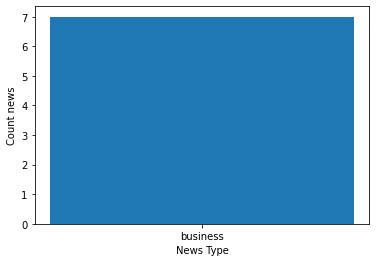

In [26]:
news_types_frequency = nltk.FreqDist(bbc_news_types)
plot_types_of_news(news_types_frequency)

In [27]:
def get_bbc_news_datetime(links):
    times = []
    for l in links:
        page = get_page_content(l)
        soup = create_soup(page)
        attributes = str(soup.find('time'))
        pat = r'\d{4}-\d{2}-\d{2}'
        obj = re.findall(pat, attributes)
        times.append(obj[0])
    return times

In [28]:
bbc_news_timestamp = get_bbc_news_datetime(extracted_bbc_links)
bbc_news_timestamp

['2021-08-11',
 '2021-08-10',
 '2021-08-11',
 '2021-08-10',
 '2021-08-11',
 '2021-08-10',
 '2021-08-11']

In [29]:
def get_bbc_news_headlines(links):
    headlines = []
    for l in links:
        page = get_page_content(l)
        soup = create_soup(page)
        headlines.append(soup.find('h1').text)
    return headlines

In [30]:
bbc_news_headlines = get_bbc_news_headlines(extracted_bbc_links)
bbc_news_headlines

['Deliveroo orders double as lockdown habits endure',
 'Amazon to pay out over defective third party goods',
 'Working from home job adverts rise',
 'Hackers steal $600m in major cryptocurrency heist',
 'China tech giant Xiaomi aims at global smartphone top spot',
 'Covid: Should I be working from home or going back to the office?',
 'Google may cut pay of staff who work from home']

In [31]:
def get_bbc_news_articles_content(links):
    content = []
    for l in links:
        page = get_page_content(l)
        soup = create_soup(page)
        content.append("".join([line.text for line in soup.find_all('div', {'data-component':"text-block"})]))
    return content

In [32]:
bbc_news_articles_content = get_bbc_news_articles_content(extracted_bbc_links)
bbc_news_articles_content

['Deliveroo has said demand for its services has strengthened despite Covid restrictions easing.The food delivery firm saw orders double to 148.8 million in the first half of this year, while the value of its transactions also doubled.At the same time, it narrowed its pre-tax losses to Â£104.8m, as against Â£128.4m a year earlier.It was the first set of results from the company since it floated on the stock market in March.Deliveroo initially listed on the London stock exchange at 390p a share, but the price fell sharply on the opening day of trading, 31 March.On Monday, its shares rallied on the news that German rival Delivery Hero had bought a 5% stake in the company worth Â£284m.But in Wednesday trading, it was down 3.3% at 351p.Cooped-up consumers flocked to order from Deliveroo during the earlier stages of the pandemic, when restaurants were closed and people switched to home deliveries.The firm said it expected customer behaviour to moderate later in the year, but it remained "ex

For more clarity we want to get our data to DataFrame. For now we want to have columns for article headline, context, date and type.

For that we need to get content and headline from every article. We already have article type and date.

But firstly we have saved data from previous days. So let's get DataFrame and than add new data.

DF is stored in **data** folder into csv file.

In [33]:
def get_dataframe_from_csv(path):
    df = pd.read_csv(path)
    return df

One big problem occurs when we run this notebook several times in one day. We will add the same rows. So let's make function that removes diplicating rows.

In [34]:
def remove_duplicating_rows(dataframe):
    duplicated = dataframe[dataframe.duplicated()]
    dataframe.drop(duplicated.index, axis=0, inplace=True)
    return dataframe.reset_index(drop=True)

We want just news about business, investing, tech and economy. Create function remove_usless_news().

In [35]:
def remove_usless_news(dataframe):
    #Yes it is ugly but it is working
    dataframe.drop(dataframe[(dataframe['news_type'] != 'business') &  (dataframe['news_type'] != 'tech') & (dataframe['news_type'] != 'investing') & (dataframe['news_type'] != 'economy')].index, axis=0, inplace=True)
    return dataframe.reset_index(drop=True)

We have our dates, types, content and headline and now is time to add them to dataframe.

Add BBC or CNN news to dataframe.

In [36]:
def add_bbc_or_cnn_news_to_dataframe(dataframe, data, source):
    for i in range(0, len(data[0])):
        dataframe.loc[len(dataframe)] = [data[0][i], data[1][i], data[2][i], data[3][i], source]
    dataframe['date'] = pd.to_datetime(dataframe['date'])

###### 2.Text Analisys

In [37]:
filename = 'news'
path = 'data/'+filename
text_data = get_dataframe_from_csv(path)
cnn_data = [cnn_news_headlines, cnn_news_articles_content, cnn_news_timestamp, cnn_news_types]
bbc_data = [bbc_news_headlines, bbc_news_articles_content, bbc_news_timestamp, bbc_news_types]
add_bbc_or_cnn_news_to_dataframe(text_data, cnn_data, "CNN")
add_bbc_or_cnn_news_to_dataframe(text_data, bbc_data, "BBC")

In [38]:
text_data = remove_duplicating_rows(text_data)
text_data = remove_usless_news(text_data)

In [39]:
text_data

,headline,content,date,news_type,source
0,Alibaba fires employee accused of sexual assau...,The company on Monday said it has fired an emp...,2021-08-09,tech,CNN
1,Twitter suspends Marjorie Taylor Greene's acco...,Greene tweeted on Monday that the Food and Dru...,2021-08-10,tech,CNN
2,Why Silicon Valley is betting on making this d...,The metaverse was originally conceived as the ...,2021-08-08,tech,CNN
3,AMC is playing to the Reddit crowd,A version of this story first appeared in CNN ...,2021-08-10,investing,CNN
4,SoftBank's CEO went big on China. Now he's pul...,The Japanese billionaire said at an earnings p...,2021-08-10,investing,CNN
5,Warren Buffett is buying more of his own stock...,Berkshire (BRKB) reported strong second quarte...,2021-08-09,investing,CNN
6,You might be able to retire earlier than you t...,Financial Independence Retire Early -- or FIRE...,2021-08-09,business,CNN
7,Inflation wiped out America's pay raises,But those fatter paychecks aren't going as far...,2021-08-10,business,CNN
8,Why big chains aren't requiring vaccines for c...,Representatives for retailers and restaurants ...,2021-08-09,business,CNN
9,JetBlue to launch NY-UK flights despite pandemic,JetBlue has said the Covid pandemic will not s...,2021-08-10,business,BBC


Save changed DF to .csv file

In [40]:
def save_dataframe_to_csv(dataframe, filename):
    path = "data/" + filename
    dataframe.to_csv(path, index=False)

In [41]:
save_dataframe_to_csv(text_data, 'news')

In [42]:
text_data

,headline,content,date,news_type,source
0,Alibaba fires employee accused of sexual assau...,The company on Monday said it has fired an emp...,2021-08-09,tech,CNN
1,Twitter suspends Marjorie Taylor Greene's acco...,Greene tweeted on Monday that the Food and Dru...,2021-08-10,tech,CNN
2,Why Silicon Valley is betting on making this d...,The metaverse was originally conceived as the ...,2021-08-08,tech,CNN
3,AMC is playing to the Reddit crowd,A version of this story first appeared in CNN ...,2021-08-10,investing,CNN
4,SoftBank's CEO went big on China. Now he's pul...,The Japanese billionaire said at an earnings p...,2021-08-10,investing,CNN
5,Warren Buffett is buying more of his own stock...,Berkshire (BRKB) reported strong second quarte...,2021-08-09,investing,CNN
6,You might be able to retire earlier than you t...,Financial Independence Retire Early -- or FIRE...,2021-08-09,business,CNN
7,Inflation wiped out America's pay raises,But those fatter paychecks aren't going as far...,2021-08-10,business,CNN
8,Why big chains aren't requiring vaccines for c...,Representatives for retailers and restaurants ...,2021-08-09,business,CNN
9,JetBlue to launch NY-UK flights despite pandemic,JetBlue has said the Covid pandemic will not s...,2021-08-10,business,BBC


Types of DataFrame are:

In [43]:
text_data.dtypes

headline             object
content              object
date         datetime64[ns]
news_type            object
source               object
dtype: object

Content from first article:

In [44]:
content = text_data.loc[0]['content']
print(text_data.loc[0]['headline'])

Alibaba fires employee accused of sexual assault as pressure mounts on Chinese tech


It our text there are stopwords - high-frequency words like the, to and also that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts.

So we  will remove them from article text.

Firstly let's see what english stopwords are. From NLTK library has a built-in module with stopwords.

In [45]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [60]:
content

'The company on Monday said it has fired an employee after he was accused of sexually assaulting a woman who also works at Alibaba (BABA). The man confessed to actions that Alibaba deemed "in serious violation of company policy," according to a memo sent by Alibaba Group chairman and CEO Daniel Zhang to employees.Two senior employees also resigned after they "failed to prioritize employee protection," according to Zhang\'s memo."Alibaba Group has a zero-tolerance policy against sexual misconduct, and ensuring a safe workplace for all our employees is Alibaba\'s top priority," a company spokesperson said in a statement to CNN Business.The allegations — which were widely circulated on Chinese social media over the weekend — have rocked Alibaba at a time when it and other Chinese tech companies are already facing incredible scrutiny from Chinese regulators over their business. The claims triggered public outcry as many criticized the company for its handling of the situation. The controve

if we discover the text more carefully to see that some sentences are merged. There is no space after some of punctuation marks, like: a company spokesperson said in a statement to CNN **Business.The** allegations — which were widely circulated on Chinese social media over the weekend. If we tokenize this sentence we will have ```Business.The``` as token. We do not want that to happen.

In [47]:
def add_whitespace_after_punctuation_mark(text):
    for i in range(0,len(text) - 1):
        if text[i] in '.?!':
            if text[i+1] != ' ' and text[i+1] not in '.?!':
                text = text[:i+1] + ' ' + text[i+1:]
    return text

In [48]:
text = add_whitespace_after_punctuation_mark(content)
text#[:1200]

'The company on Monday said it has fired an employee after he was accused of sexually assaulting a woman who also works at Alibaba (BABA). The man confessed to actions that Alibaba deemed "in serious violation of company policy," according to a memo sent by Alibaba Group chairman and CEO Daniel Zhang to employees. Two senior employees also resigned after they "failed to prioritize employee protection," according to Zhang\'s memo. "Alibaba Group has a zero-tolerance policy against sexual misconduct, and ensuring a safe workplace for all our employees is Alibaba\'s top priority," a company spokesperson said in a statement to CNN Business. The allegations — which were widely circulated on Chinese social media over the weekend — have rocked Alibaba at a time when it and other Chinese tech companies are already facing incredible scrutiny from Chinese regulators over their business. The claims triggered public outcry as many criticized the company for its handling of the situation. The contr

Now ```Business. The``` is OK.

Tokenize our text into words. 

In [49]:
tokens = word_tokenize(text)
tokens

['The',
 'company',
 'on',
 'Monday',
 'said',
 'it',
 'has',
 'fired',
 'an',
 'employee',
 'after',
 'he',
 'was',
 'accused',
 'of',
 'sexually',
 'assaulting',
 'a',
 'woman',
 'who',
 'also',
 'works',
 'at',
 'Alibaba',
 '(',
 'BABA',
 ')',
 '.',
 'The',
 'man',
 'confessed',
 'to',
 'actions',
 'that',
 'Alibaba',
 'deemed',
 '``',
 'in',
 'serious',
 'violation',
 'of',
 'company',
 'policy',
 ',',
 "''",
 'according',
 'to',
 'a',
 'memo',
 'sent',
 'by',
 'Alibaba',
 'Group',
 'chairman',
 'and',
 'CEO',
 'Daniel',
 'Zhang',
 'to',
 'employees',
 '.',
 'Two',
 'senior',
 'employees',
 'also',
 'resigned',
 'after',
 'they',
 '``',
 'failed',
 'to',
 'prioritize',
 'employee',
 'protection',
 ',',
 "''",
 'according',
 'to',
 'Zhang',
 "'s",
 'memo',
 '.',
 '``',
 'Alibaba',
 'Group',
 'has',
 'a',
 'zero-tolerance',
 'policy',
 'against',
 'sexual',
 'misconduct',
 ',',
 'and',
 'ensuring',
 'a',
 'safe',
 'workplace',
 'for',
 'all',
 'our',
 'employees',
 'is',
 'Alibaba',


Remove stopwords and non alphabetic words then we will set every word in lower case. There are gonna be two or more occurences for one word - ```like and Like```, if we don't set words to lower case. That is why we want every single word to be in lower case so the analysis will be more accurate.

In [50]:
def get_meaningful_words(words):
    meaningful_words = []
    for w in words:
        if w.lower() not in stopwords.words('english') and w.lower().isalpha():
            meaningful_words.append(w.lower())
    return meaningful_words

In [51]:
meaningful_words = get_meaningful_words(tokens)
meaningful_words

['company',
 'monday',
 'said',
 'fired',
 'employee',
 'accused',
 'sexually',
 'assaulting',
 'woman',
 'also',
 'works',
 'alibaba',
 'baba',
 'man',
 'confessed',
 'actions',
 'alibaba',
 'deemed',
 'serious',
 'violation',
 'company',
 'policy',
 'according',
 'memo',
 'sent',
 'alibaba',
 'group',
 'chairman',
 'ceo',
 'daniel',
 'zhang',
 'employees',
 'two',
 'senior',
 'employees',
 'also',
 'resigned',
 'failed',
 'prioritize',
 'employee',
 'protection',
 'according',
 'zhang',
 'memo',
 'alibaba',
 'group',
 'policy',
 'sexual',
 'misconduct',
 'ensuring',
 'safe',
 'workplace',
 'employees',
 'alibaba',
 'top',
 'priority',
 'company',
 'spokesperson',
 'said',
 'statement',
 'cnn',
 'business',
 'allegations',
 'widely',
 'circulated',
 'chinese',
 'social',
 'media',
 'weekend',
 'rocked',
 'alibaba',
 'time',
 'chinese',
 'tech',
 'companies',
 'already',
 'facing',
 'incredible',
 'scrutiny',
 'chinese',
 'regulators',
 'business',
 'claims',
 'triggered',
 'public',
 

Ratio of meaningful words compared to all words in text is:

In [52]:
def meaningful_to_all_words(meaningful_words, text):
    return len(meaningful_words) / len(text.split())

In [53]:
meaningful_to_all_words(meaningful_words, content)

0.5514541387024608

This result shows how useful it is tokenize text, remove stop words, punctuation, and change uppercase to lowercase. This way we save time and memory. Mostly time, because if we prepare the data for some kind of modeling we will have less information, but at the expense of more accurate and specific data for the text.

Let's see the 

Frequency to all words plot

Determine what is the text mood

Lemmatization and steming

Examine parts of speech and plot results

Examine n-grams

Again plot new data and freq

Perform summarization

Compare your summarization with build in modules from libraries

Hypotesys:

Are there more words with lenght over 6 characters

Create FreqList with cleaned words.

In [54]:
freq_words = nltk.FreqDist(meaningful_words)
freq_words

FreqDist({'company': 14, 'employees': 13, 'alibaba': 12, 'zhang': 10, 'business': 7, 'culture': 7, 'woman': 6, 'chinese': 6, 'wrote': 6, 'said': 5, ...})

Let's take a closer look at the dictionary of common words. In fact, let's plot some of them using barchart. Let's look at a small hypothesis. Are there words that are outliers. That is, whether there are several words that are repeated more than other words

In [55]:
def plot_most_frequent_words(words_number, freq_words):
    most_common_words = freq_words.most_common(words_number)
    plt.bar([w[0] for w in most_common_words], [w[1] for w in most_common_words])

    plt.title(f"Top {words_number} most frequent words count")
    plt.xlabel("Words")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

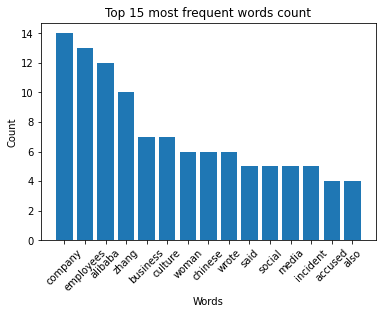

In [56]:
freq_words
number_words = 15
plot_most_frequent_words(number_words, freq_words)

After the observation, the hypothesis seems to be true, but let's set the words by their count

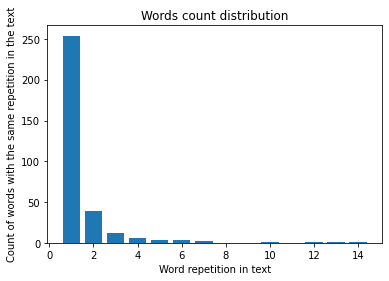

In [57]:
words_freq_count = collections.Counter(freq_words.values())
plt.bar(words_freq_count.keys(), words_freq_count.values())

plt.title(f"Words count distribution")
plt.xlabel("Word repetition in text")
plt.ylabel("Count of words with the same repetition in the text")
plt.show()

Yes, we can now conclude that there are several words that are repeated a lot in the text

In [61]:
sentences = sent_tokenize(text.replace('"', ''))
#print first 3 sentences
for s in sentences:
    print(s)
    print()

The company on Monday said it has fired an employee after he was accused of sexually assaulting a woman who also works at Alibaba (BABA).

The man confessed to actions that Alibaba deemed in serious violation of company policy, according to a memo sent by Alibaba Group chairman and CEO Daniel Zhang to employees.

Two senior employees also resigned after they failed to prioritize employee protection, according to Zhang's memo.

Alibaba Group has a zero-tolerance policy against sexual misconduct, and ensuring a safe workplace for all our employees is Alibaba's top priority, a company spokesperson said in a statement to CNN Business.

The allegations — which were widely circulated on Chinese social media over the weekend — have rocked Alibaba at a time when it and other Chinese tech companies are already facing incredible scrutiny from Chinese regulators over their business.

The claims triggered public outcry as many criticized the company for its handling of the situation.

The controve

In [69]:
sentence_value = dict()
   
for sentence in sentences:
    for word, freq in freq_words.items():
        if word in sentence.lower():
            if sentence in sentence_value:
                sentence_value[sentence] += freq
            else:
                sentence_value[sentence] = freq
                
                
# Values from every sentence
sentence_value.values()

dict_values([63, 82, 49, 77, 55, 27, 51, 38, 15, 6, 11, 15, 16, 20, 25, 38, 31, 28, 20, 13, 9, 34, 15, 17, 6, 71, 53, 21, 79, 57, 8, 20, 73, 52, 33, 28, 45, 34, 14, 60, 80, 43])

In [71]:
[v / len(k.split()) for k, v in sentence_value.items()]

[2.52,
 2.8275862068965516,
 3.0625,
 2.40625,
 1.4102564102564104,
 1.6875,
 1.5454545454545454,
 1.1515151515151516,
 0.8823529411764706,
 0.4,
 0.9166666666666666,
 0.7142857142857143,
 1.7777777777777777,
 2.5,
 1.3157894736842106,
 2.923076923076923,
 2.066666666666667,
 1.3333333333333333,
 4.0,
 3.25,
 0.6,
 4.25,
 0.8823529411764706,
 1.1333333333333333,
 0.6666666666666666,
 2.9583333333333335,
 1.7096774193548387,
 2.1,
 2.323529411764706,
 1.3902439024390243,
 1.0,
 1.5384615384615385,
 1.7804878048780488,
 1.6774193548387097,
 1.2692307692307692,
 1.2727272727272727,
 1.6666666666666667,
 1.0625,
 1.75,
 1.6666666666666667,
 2.1052631578947367,
 1.131578947368421]

###  Results

### Limitations and Future Work  (Optional)

### Conclusion

### References

https://arxiv.org/pdf/2107.14681.pdf


https://ocw.mit.edu/courses/biological-engineering/20-109-laboratory-fundamentals-in-biological-engineering-fall-2007/assignments/sci_writing_guid.pdf

https://tjzhifei.github.io/resources/NLTK.pdf